In [1]:
import os
import glob
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy.stats import skew, kurtosis
from numpy.fft import rfft, rfftfreq

plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
DATA_ROOT = r"C:\Users\jhs40\pattern_ai\DataSet\iotAnomaly_train"   # Train Set 경로 가져오기
TEST_ROOT = r"C:\Users\jhs40\pattern_ai\DataSet\iotAnomaly_test"   # TEST Set 경로 가져오기
TRAIN_DIR = os.path.join(DATA_ROOT, "csv_files")  
TEST_DIR  = os.path.join(TEST_ROOT, "csv_files")  

# 경로 내에 모든 CSV 파일을 패턴으로 가져온다.
TRAIN_PATTERN = os.path.join(TRAIN_DIR, "*.csv")
TEST_PATTERN  = os.path.join(TEST_DIR,  "*.csv")

train_files = sorted(glob.glob(TRAIN_PATTERN))
test_files  = sorted(glob.glob(TEST_PATTERN))

# 전체 파일 List 출력
print(f"Train files: {len(train_files)}개")
print(f"Test files : {len(test_files)}개")

# 실제 데이터는 R상, S상, T상이지만 csv 파일에서는 x,y,z로 되어 있으니 csv 파일 기준으로 정리한다.
SIGNAL_COLS = ["x", "y", "z"]   

SAMPLE_RATE = 2000  # CSV 파일 Row 수

# 윈도우 길이(초) & stride 비율
WINDOW_SECONDS = 0.5  # 0.5 초 단위
WINDOW_SIZE = int(SAMPLE_RATE * WINDOW_SECONDS)  # 1000 포인트
WINDOW_STRIDE_RATIO = 0.5
WINDOW_STRIDE = int(WINDOW_SIZE * WINDOW_STRIDE_RATIO)

print("WINDOW_SIZE:", WINDOW_SIZE, "WINDOW_STRIDE:", WINDOW_STRIDE)

# 메모리/속도 제어용
MAX_TRAIN_WINDOWS = 100_000   # 전체 Train 윈도우 상한
MAX_TEST_WINDOWS  = 50_000    # 전체 Test 윈도우 상한
MAX_WINDOWS_PER_TRAIN_FILE = 200
MAX_WINDOWS_PER_TEST_FILE  = 100

scaler = StandardScaler()


Train files: 58631개
Test files : 8744개
WINDOW_SIZE: 1000 WINDOW_STRIDE: 500


In [3]:

# 파일 유무 확인
if len(train_files) == 0:
    raise RuntimeError("Train 폴더에 CSV가 없습니다. TRAIN_DIR 경로를 확인하세요.")

sample_file = train_files[0]
df_preview = pd.read_csv(sample_file, nrows=5)

print("샘플 파일:", sample_file)
print("컬럼 목록:", df_preview.columns.tolist())
display(df_preview.head())


샘플 파일: C:\Users\jhs40\pattern_ai\DataSet\iotAnomaly_train\csv_files\label_00005681335550.csv
컬럼 목록: ['wavelength', 'x', 'y', 'z']


,wavelength,x,y,z
0,0.0000,1.921875,-4.043945,2.082031
1,0.0005,2.402344,-3.843750,1.641602
2,0.0010,2.682617,-3.723633,1.000977
3,0.0015,3.123047,-3.483398,0.360352
4,0.0020,3.403320,-2.842773,-0.480469


In [4]:
# 전류 시그널 값을 구분해 가져온다.
def load_signal_from_csv(file_path, signal_cols=None):
    if signal_cols is None:
        signal_cols = SIGNAL_COLS

    df = pd.read_csv(file_path)

    for c in signal_cols:
        if c not in df.columns:
            raise KeyError(f"'{c}' 컬럼을 찾을 수 없습니다. 실제 컬럼: {df.columns.tolist()}")

    signal = df[signal_cols].values.astype(np.float32)
    return signal
    



데이터셋 비교 시그널 시각화
✔ 그래프 출력: C:\Users\jhs40\pattern_ai\DataSet\iotAnomaly_train\csv_files\label_00005681335550.csv


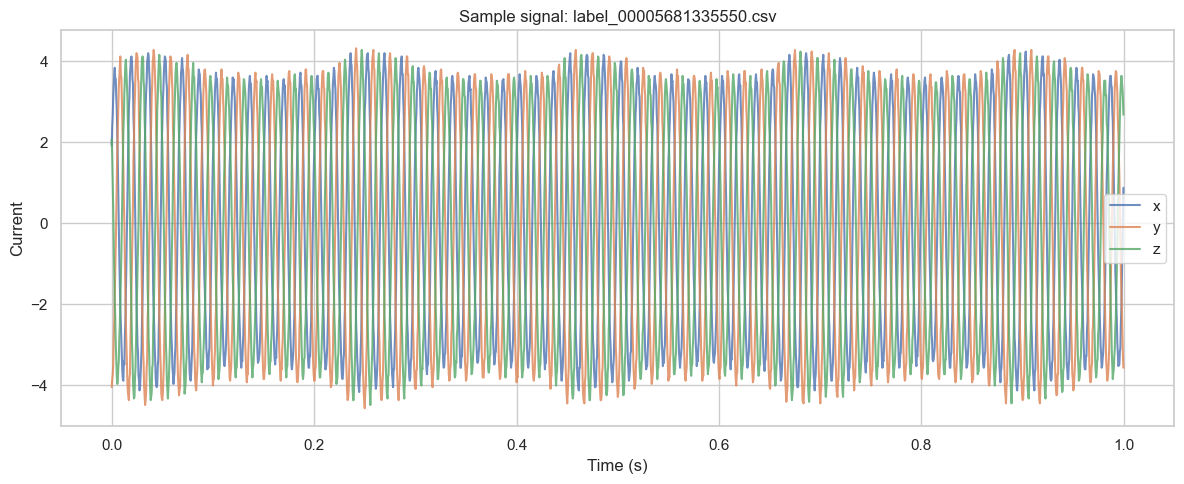

✔ 그래프 출력: C:\Users\jhs40\pattern_ai\DataSet\iotAnomaly_test\csv_files\label_00559636191676.csv


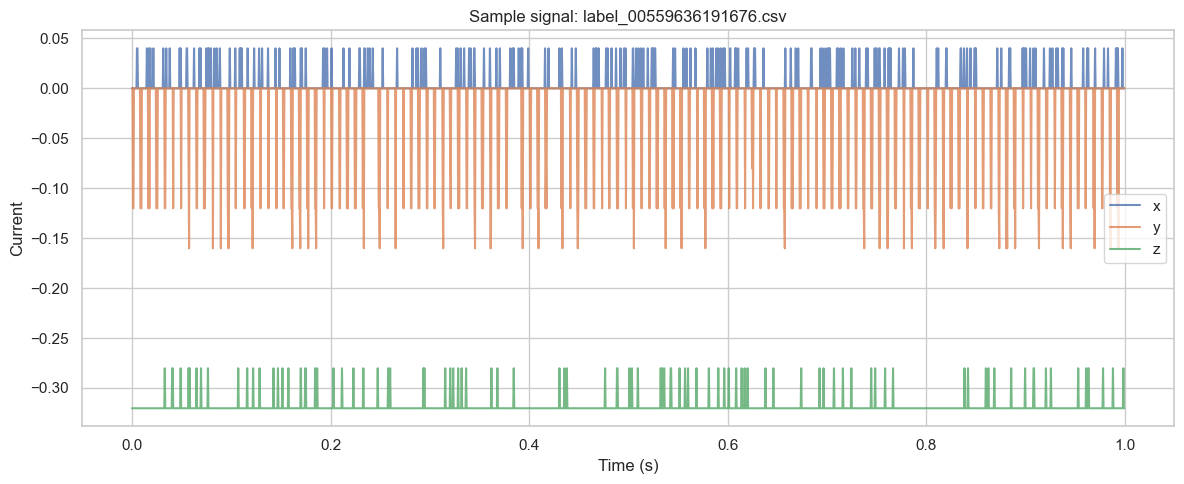

In [5]:
# 데이터 셋 형태를 비교하기 위한 파형 그리기
def plot_sample_signal(file_path, max_points=4000):
    signal = load_signal_from_csv(file_path)
    n = min(len(signal), max_points)
    t = np.arange(n) / SAMPLE_RATE

    plt.figure(figsize=(12, 5))
    for i, name in enumerate(SIGNAL_COLS):
        plt.plot(t, signal[:n, i], label=name, alpha=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Current")
    plt.title(f"Sample signal: {os.path.basename(file_path)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

target_files = [
    "label_00005681335550.csv",  # 정상 샘플
    "label_00559636191676.csv"   # 비정상 샘플
]

print("데이터셋 비교 시그널 시각화")

for fname in target_files:
    # Train/Test 어디에 있든 경로를 자동으로 탐색
    candidates = [fp for fp in train_files + test_files if fname in fp]

    if len(candidates) == 0:
        print(f"❌ 파일을 찾을 수 없습니다: {fname}")
        continue

    fp = candidates[0]  # 가장 첫 번째 매칭 경로 사용
    print(f"✔ 그래프 출력: {fp}")
    plot_sample_signal(fp)



In [6]:
# 윈도우 슬라이싱 + 피처 추출

def sliding_windows(signal, window_size=WINDOW_SIZE, stride=WINDOW_STRIDE):
    N = signal.shape[0]
    if N < window_size:
        return np.empty((0, window_size, signal.shape[1]), dtype=signal.dtype)

    windows = []
    for start in range(0, N - window_size + 1, stride):
        end = start + window_size
        windows.append(signal[start:end])
    if not windows:
        return np.empty((0, window_size, signal.shape[1]), dtype=signal.dtype)
    return np.stack(windows, axis=0)


def extract_features_from_window(window, sample_rate=SAMPLE_RATE):
    feats = []

    for ch in range(window.shape[1]):
        x = window[:, ch]

        # 통계 피처
        mean_ = np.mean(x)
        std_  = np.std(x)
        rms_  = np.sqrt(np.mean(x**2))
        max_  = np.max(x)
        min_  = np.min(x)
        p2p_  = max_ - min_
        skew_ = skew(x)
        kurt_ = kurtosis(x)

        feats.extend([mean_, std_, rms_, max_, min_, p2p_, skew_, kurt_])

        # 주파수 피처
        yf = np.abs(rfft(x))
        xf = rfftfreq(len(x), 1.0 / sample_rate)

        energy = np.sum(yf**2)
        main_freq = xf[np.argmax(yf)]
        feats.extend([energy, main_freq])

    return np.array(feats, dtype=np.float32)


def extract_features_from_signal(signal, max_windows=None):
    windows = sliding_windows(signal)
    num_windows = windows.shape[0]

    if num_windows == 0:
        return np.empty((0, 0), dtype=np.float32)

    idx = np.arange(num_windows)
    if (max_windows is not None) and (num_windows > max_windows):
        idx = np.random.choice(idx, size=max_windows, replace=False)
        windows = windows[idx]

    features = [extract_features_from_window(w) for w in windows]
    return np.stack(features, axis=0)


In [7]:
from tqdm.notebook import tqdm

def build_feature_dataset_train(
    file_list,
    max_total_windows=MAX_TRAIN_WINDOWS,
    max_windows_per_file=MAX_WINDOWS_PER_TRAIN_FILE
):
    X_list = []
    total = 0

    for i, fp in enumerate(tqdm(file_list, desc="Building TRAIN features")):
        if total >= max_total_windows:
            break

        signal = load_signal_from_csv(fp)
        remain = max_total_windows - total
        per_file = min(max_windows_per_file, remain)

        feats = extract_features_from_signal(signal, max_windows=per_file)
        if feats.size == 0:
            continue

        X_list.append(feats)
        total += feats.shape[0]

        #if (i + 1) % 10 == 0:
        #    print(f"[Train] {i+1}/{len(file_list)} files, total windows: {total}")

    if not X_list:
        raise RuntimeError("Train에서 추출된 윈도우가 없습니다. WINDOW_SIZE/STRIDE를 확인하세요.")

    X_train_raw = np.concatenate(X_list, axis=0)
    print("✅ X_train_raw shape:", X_train_raw.shape)
    return X_train_raw


def build_feature_dataset_test(
    file_list,
    max_total_windows=MAX_TEST_WINDOWS,
    max_windows_per_file=MAX_WINDOWS_PER_TEST_FILE
):
    X_list = []
    total = 0

    for i, fp in enumerate(tqdm(file_list, desc="Building TEST features")):
        if total >= max_total_windows:
            break

        signal = load_signal_from_csv(fp)
        remain = max_total_windows - total
        per_file = min(max_windows_per_file, remain)

        feats = extract_features_from_signal(signal, max_windows=per_file)
        if feats.size == 0:
            continue

        X_list.append(feats)
        total += feats.shape[0]

        #if (i + 1) % 10 == 0:
        #    print(f"[Test] {i+1}/{len(file_list)} files, total windows: {total}")

    if not X_list:
        raise RuntimeError("Test에서 추출된 윈도우가 없습니다. WINDOW_SIZE/STRIDE를 확인하세요.")

    X_test_raw = np.concatenate(X_list, axis=0)
    print("✅ X_test_raw shape:", X_test_raw.shape)
    return X_test_raw


# 실제 실행
X_train_raw = build_feature_dataset_train(train_files)
X_test_raw  = build_feature_dataset_test(test_files)


Building TRAIN features:   0%|          | 0/58631 [00:00<?, ?it/s]

✅ X_train_raw shape: (100000, 30)


Building TEST features:   0%|          | 0/8744 [00:00<?, ?it/s]

✅ X_test_raw shape: (26232, 30)


In [8]:
# 정상 유무 판정에 대한 데이터가 없으므로 스케일링만 진행한다.

X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("스케일링 완료.")

X_train shape: (100000, 30)
X_test shape : (26232, 30)
스케일링 완료.


In [9]:
# Isolation 형태 분석 진행

iso_clf = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination="auto",  # Train이 전부 정상 데이터라고 가정
    random_state=SEED,
    n_jobs=-1
)

iso_clf.fit(X_train)

# score_samples: 정상일수록 점수가 큼 → 이상 점수는 -score_samples
iso_scores_test = -iso_clf.score_samples(X_test)
print("Isolation Forest 예시 점수:", iso_scores_test[:5])


Isolation Forest 예시 점수: [0.39460698 0.39548024 0.3981289  0.4431199  0.44521589]


In [10]:
# One-Class SVM 활용 분석 진행

MAX_SVM_SAMPLES = 20_000
if len(X_train) > MAX_SVM_SAMPLES:
    idx = np.random.choice(len(X_train), size=MAX_SVM_SAMPLES, replace=False)
    X_train_svm = X_train[idx]
else:
    X_train_svm = X_train

print("One-Class SVM 학습 데이터 크기:", X_train_svm.shape)

oc_svm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.05  # 이상 비율 추정치(조절 가능)
)

oc_svm.fit(X_train_svm)

# decision_function: 값이 작을수록 이상 → 이상 점수 = -decision_function
svm_scores_test = -oc_svm.decision_function(X_test)
print("One-Class SVM 예시 점수:", svm_scores_test[:5])


One-Class SVM 학습 데이터 크기: (20000, 30)
One-Class SVM 예시 점수: [-7.47034739 -7.80392665 -8.12902556 -3.2721896  -3.57256721]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │             990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,334 (13.02 KB)

 Trainable params: 3,334 (13.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6462 - val_loss: 1.6113
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3095 - val_loss: 1.4139
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1960 - val_loss: 1.4430
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 - val_loss: 1.4189
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106 - val_loss: 1.3079
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0932 - val_loss: 1.2319
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0894 - val_loss: 1.2060
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0848 - val_loss: 1.1480
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0790 - val_loss: 1.1121
Epoch 10/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0778 - val_loss: 1.1358
Epoch 11/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0733 - val_loss: 1.0896
Epoch 12/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

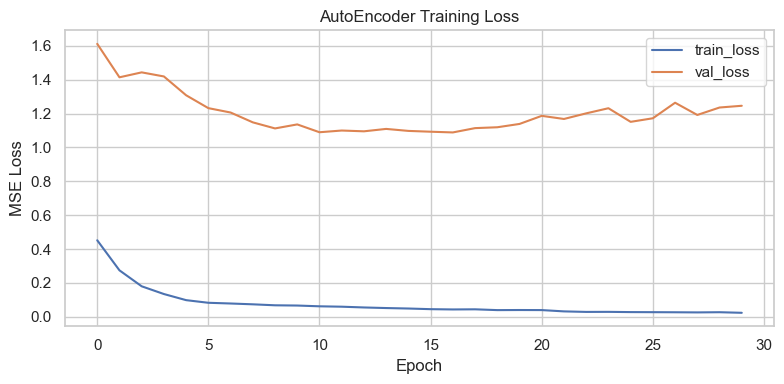

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AutoEncoder 예시 점수: [0.00049488 0.00058289 0.00077445 0.00395402 0.00363926]


In [11]:
# AutoEncoder 기반 분석 진행

input_dim = X_train.shape[1]
encoding_dim = max(8, input_dim // 4)  # 너무 작지 않게

inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(encoding_dim * 4, activation="relu")(inputs)
x = layers.Dense(encoding_dim * 2, activation="relu")(x)
encoded = layers.Dense(encoding_dim, activation="relu")(x)

x = layers.Dense(encoding_dim * 2, activation="relu")(encoded)
x = layers.Dense(encoding_dim * 4, activation="relu")(x)
decoded = layers.Dense(input_dim, activation="linear")(x)

autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse"
)

autoencoder.summary()

BATCH_SIZE = 512
EPOCHS = 30

history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# 학습 곡선
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AutoEncoder Training Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Test 재구성 오차 기반 이상점수
X_test_recon = autoencoder.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
ae_mse = np.mean((X_test - X_test_recon)**2, axis=1)
ae_scores_test = ae_mse

print("AutoEncoder 예시 점수:", ae_scores_test[:5])


,iso_score,svm_score,ae_score
count,26232.000000,26232.000000,26232.000000
mean,0.451787,2.477753,0.762032
std,0.096602,33.991686,30.378012
min,0.375460,-14.605557,0.000101
25%,0.394766,-3.702899,0.000366
50%,0.407786,-2.148446,0.000549
75%,0.452320,-1.434713,0.001163
max,0.821840,296.504517,2709.735352


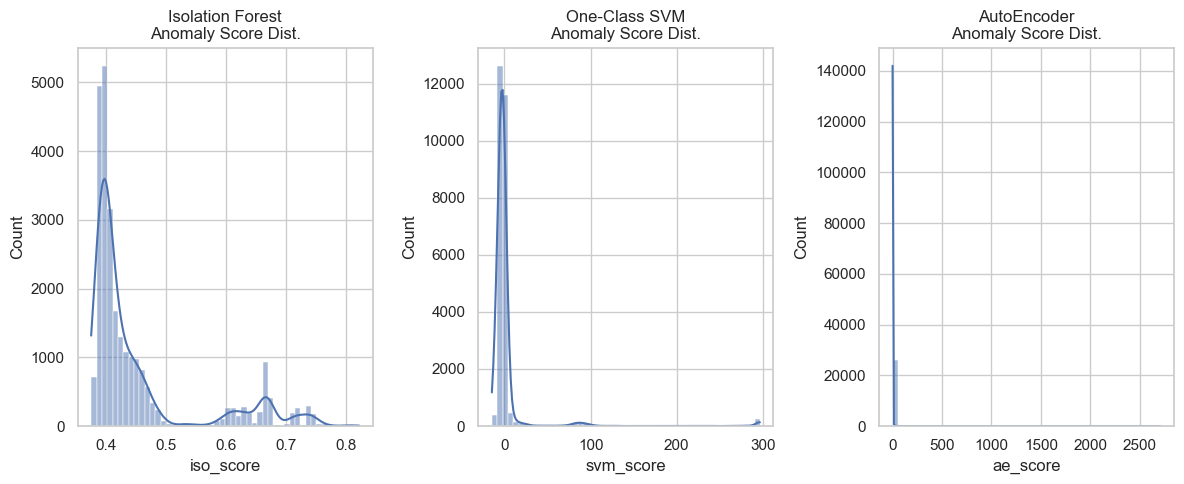

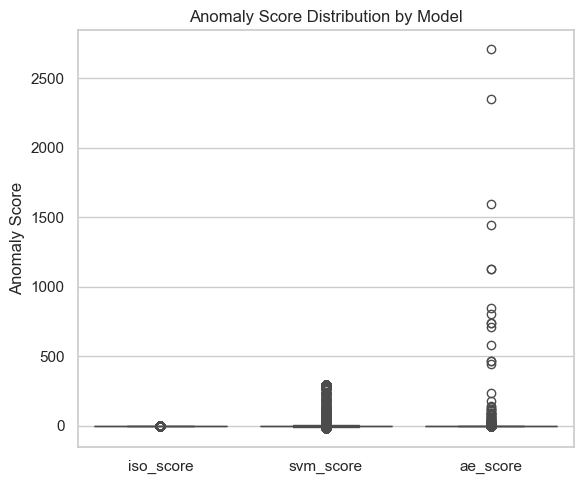

In [12]:
# 모델별 이상점수 통계
score_df = pd.DataFrame({
    "iso_score": iso_scores_test,
    "svm_score": svm_scores_test,
    "ae_score": ae_scores_test,
})

display(score_df.describe())  # 기본 통계량

# 히스토그램 + KDE (모델별 이상 점수 분포)
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(score_df["iso_score"], bins=50, kde=True)
plt.title("Isolation Forest\nAnomaly Score Dist.")

plt.subplot(1, 3, 2)
sns.histplot(score_df["svm_score"], bins=50, kde=True)
plt.title("One-Class SVM\nAnomaly Score Dist.")

plt.subplot(1, 3, 3)
sns.histplot(score_df["ae_score"], bins=50, kde=True)
plt.title("AutoEncoder\nAnomaly Score Dist.")

plt.tight_layout()
plt.show()

# 박스플롯으로 전체 분포 범위 비교
plt.figure(figsize=(6, 5))
sns.boxplot(data=score_df)
plt.title("Anomaly Score Distribution by Model")
plt.ylabel("Anomaly Score")
plt.tight_layout()
plt.show()


상관계수 행렬:


,iso_score,svm_score,ae_score
iso_score,1.000000,0.454116,0.054543
svm_score,0.454116,1.000000,0.215839
ae_score,0.054543,0.215839,1.000000


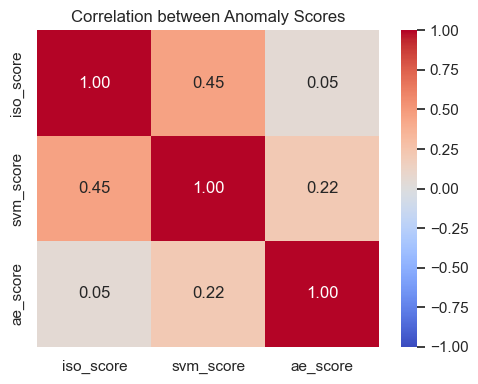

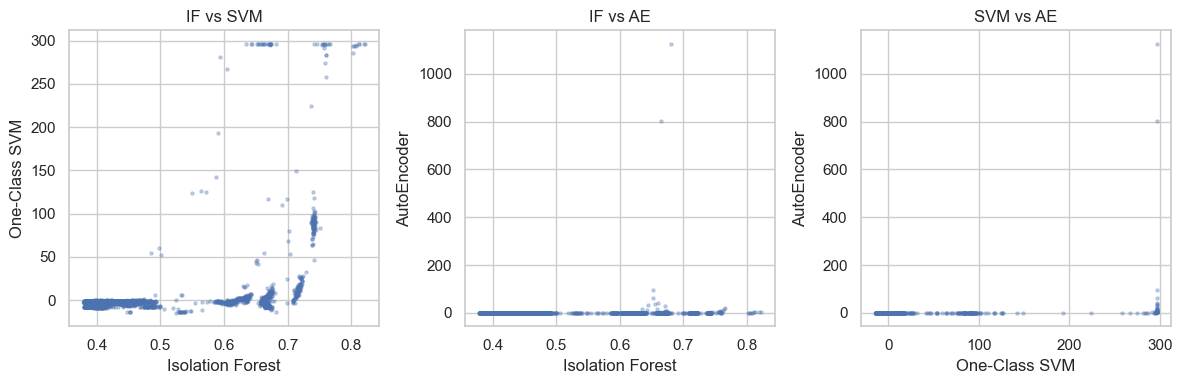

In [13]:
# 상관계수 행렬
corr = score_df.corr()
print("상관계수 행렬:")
display(corr)

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between Anomaly Scores")
plt.tight_layout()
plt.show()

# 모델 간 scatter plot (샘플 일부만 표시해서 시각화)
N_SAMPLE = min(5000, len(score_df))
sample_idx = np.random.choice(len(score_df), size=N_SAMPLE, replace=False)
sample_scores = score_df.iloc[sample_idx]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(sample_scores["iso_score"], sample_scores["svm_score"], s=5, alpha=0.3)
plt.xlabel("Isolation Forest")
plt.ylabel("One-Class SVM")
plt.title("IF vs SVM")

plt.subplot(1, 3, 2)
plt.scatter(sample_scores["iso_score"], sample_scores["ae_score"], s=5, alpha=0.3)
plt.xlabel("Isolation Forest")
plt.ylabel("AutoEncoder")
plt.title("IF vs AE")

plt.subplot(1, 3, 3)
plt.scatter(sample_scores["svm_score"], sample_scores["ae_score"], s=5, alpha=0.3)
plt.xlabel("One-Class SVM")
plt.ylabel("AutoEncoder")
plt.title("SVM vs AE")

plt.tight_layout()
plt.show()


Top-1000 기준 윈도우 겹침 개수:
  IF ∩ SVM : 721
  IF ∩ AE  : 180
  SVM ∩ AE : 432
  IF ∩ SVM ∩ AE (모두 이상으로 보는 구간): 180


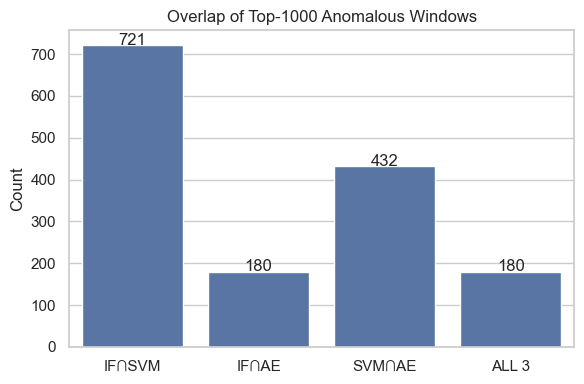

In [14]:
# 모델별 이상 분석 유사성 비교
TOP_N = 1000  # 상위 N개 윈도우를 "가장 이상"으로 본다고 가정

# 각 모델별 Top-N 인덱스
top_iso_idx = np.argsort(-score_df["iso_score"].values)[:TOP_N]
top_svm_idx = np.argsort(-score_df["svm_score"].values)[:TOP_N]
top_ae_idx  = np.argsort(-score_df["ae_score"].values)[:TOP_N]

set_iso = set(top_iso_idx)
set_svm = set(top_svm_idx)
set_ae  = set(top_ae_idx)

# 모델 간 겹치는 윈도우 개수
iso_svm_overlap = len(set_iso & set_svm)
iso_ae_overlap  = len(set_iso & set_ae)
svm_ae_overlap  = len(set_svm & set_ae)
all_overlap     = len(set_iso & set_svm & set_ae)

print(f"Top-{TOP_N} 기준 윈도우 겹침 개수:")
print(f"  IF ∩ SVM : {iso_svm_overlap}")
print(f"  IF ∩ AE  : {iso_ae_overlap}")
print(f"  SVM ∩ AE : {svm_ae_overlap}")
print(f"  IF ∩ SVM ∩ AE (모두 이상으로 보는 구간): {all_overlap}")

# 간단한 바 차트 시각화
overlap_labels = ["IF∩SVM", "IF∩AE", "SVM∩AE", "ALL 3"]
overlap_values = [iso_svm_overlap, iso_ae_overlap, svm_ae_overlap, all_overlap]

plt.figure(figsize=(6, 4))
sns.barplot(x=overlap_labels, y=overlap_values)
plt.title(f"Overlap of Top-{TOP_N} Anomalous Windows")
plt.ylabel("Count")
for i, v in enumerate(overlap_values):
    plt.text(i, v + 1, str(v), ha="center")
plt.tight_layout()
plt.show()


In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

!pip install openpyxl

# 1. 기본 점수 DataFrame 만들기 (윈도우 단위)
scores_df = pd.DataFrame({
    "window_index": np.arange(len(iso_scores_test)),
    "iso_score_raw": iso_scores_test,
    "svm_score_raw": svm_scores_test,
    "ae_score_raw":  ae_scores_test,
})

# 2. 0~1 정규화 점수도 같이 넣기 (비교용)
scaler = MinMaxScaler()
scores_norm = scaler.fit_transform(scores_df[["iso_score_raw", "svm_score_raw", "ae_score_raw"]])
scores_df[["iso_score_norm", "svm_score_norm", "ae_score_norm"]] = scores_norm

display(scores_df.head())
print("총 윈도우 수:", len(scores_df))

# 3. 저장 경로 설정 + 폴더 생성
save_dir = r"C:\Users\jhs40\pattern_ai\result"
os.makedirs(save_dir, exist_ok=True)

excel_path = os.path.join(save_dir, "test_anomaly_scores_by_window.xlsx")

# 4. 엑셀로 저장 (한 시트에 통합)
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    scores_df.to_excel(writer, sheet_name="window_scores", index=False)

print(f"완료: {excel_path}")


,window_index,iso_score_raw,svm_score_raw,ae_score_raw,iso_score_norm,svm_score_norm,ae_score_norm
0,0,0.394607,-7.470347,0.000495,0.042893,0.022935,1.453776e-07
1,1,0.395480,-7.803927,0.000583,0.044849,0.021862,1.778539e-07
2,2,0.398129,-8.129026,0.000774,0.050783,0.020817,2.485477e-07
3,3,0.443120,-3.272190,0.003954,0.151574,0.036429,1.421937e-06
4,4,0.445216,-3.572567,0.003639,0.156269,0.035463,1.305777e-06


총 윈도우 수: 26232
완료: C:\Users\jhs40\pattern_ai\result\test_anomaly_scores_by_window.xlsx
